# Calibration of the Chaboche mecanical model with least squares

## Deterministic model

The Chaboche mecanical law predicts the stress depending on the strain:
$$
\sigma = g(\epsilon,R,C,\gamma) = R + \frac{C}{\gamma} (1-\exp(-\gamma\epsilon))
$$

where:

- $\sigma$ is the stress (Pa),
- $\epsilon$ is the strain,
- $R$, $C$, $\gamma$ are the parameters.

Caution: 
* The strain $\epsilon$ is not the random error of the least squares model. 
* The stress $\sigma$ is not the standard deviation of the random noise of the output observations.

The variables have the following distributions and are supposed to be independent.

| Random var. | Distribution | 
|--|--|
| $R$ | Lognormal ($\mu = 750$ MPa, $\sigma = 11$ MPa) |
| $C$ | Normal ($\mu = 2750$ MPa, $\sigma = 250$ MPa) |
| $\gamma$ | Normal ($\mu = 10$, $\sigma = 2$) |
| $\epsilon$ | Uniform(a=0, b=0.07). |

## Parameters to calibrate

The vector of parameters to calibrate is: 
$$
\theta = (R,C,\gamma).
$$

We set:

- $R = 750\times 10^6$,
- $C = 2750\times 10^6$,
- $\gamma = 10$.

## Observations

In order to create a calibration problem, we make the hypothesis that the strain has the following distribution:
$$
\epsilon \sim Uniform(0,0.07).
$$

Moreover, we consider a gaussian noise on the observed constraint:
$$
\epsilon_\sigma \sim \mathcal{N} \left(0,10\times 10^6\right)
$$

and we make the hypothesis that the observation errors are independent.
We set the number of observations to:
$$
n = 100.
$$

We generate a Monte-Carlo sample with size $n$:
$$
\sigma_i = g(\epsilon_i,R,C,\gamma) + (\epsilon_\sigma)_i, 
$$

for $i = 1,..., n$.
The observations are the pairs $\{(\epsilon_i,\sigma_i)\}_{i=1,...,n}$, i.e. each observation is a couple made of the strain and the corresponding stress.

## Thanks to

- Antoine Dumas, Phimeca


## References

- J. Lemaitre and J. L. Chaboche (2002) "Mechanics of solid materials" Cambridge University Press.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

Define the model.

In [2]:
def modelChaboche(X):
    strain, R, C, gamma = X
    stress = R + C * (1.0 - np.exp(-gamma * strain)) / gamma
    return [stress]

Create the Python function.

In [3]:
g = ot.PythonFunction(4, 1, modelChaboche)
g.setInputDescription(["Strain", "R", "C", "Gamma"])
g.setOutputDescription(["Stress"])

The goal of the next cells is to define the input and output observations. 

We first define the random vector. Notice that the `Dirac` distribution is used to define a constant distribution: its parameter is the only value that the random variable can have. 

In [4]:
Strain = ot.Uniform(0.0, 0.07)
unknownR = 750e6
unknownC = 2750e6
unknownGamma = 10.0
R = ot.Dirac(unknownR)
C = ot.Dirac(unknownC)
Gamma = ot.Dirac(unknownGamma)

Strain.setDescription(["Strain"])
R.setDescription(["R"])
C.setDescription(["C"])
Gamma.setDescription(["Gamma"])

Create the joint input distribution function.

In [5]:
inputRandomVector = ot.ComposedDistribution([Strain, R, C, Gamma])

Create the Monte-Carlo sample.

In [6]:
sampleSize = 100
inputSample = inputRandomVector.getSample(sampleSize)
outputStress = g(inputSample)
outputStress[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[y0] data=[[8.48052e+08],[8.76764e+08],[7.74846e+08],[7.56186e+08],[8.09312e+08]]

Plot the histogram of the output.

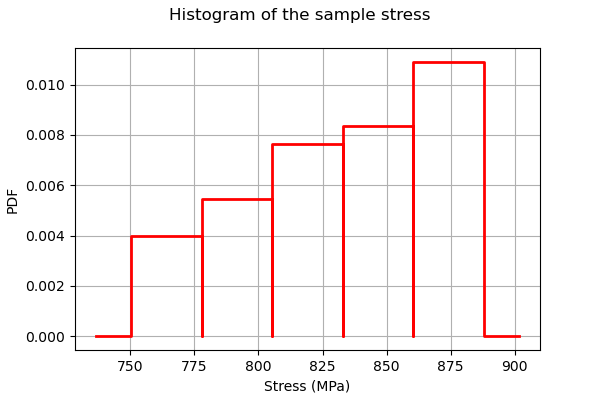

In [7]:
histoGraph = ot.HistogramFactory().build(outputStress / 1.0e6).drawPDF()
histoGraph.setTitle("Histogram of the sample stress")
histoGraph.setXTitle("Stress (MPa)")
histoGraph.setLegends([""])
histoGraph

Generate Gaussian observation noise. This random noise is added to the output of the model in order to produce the output observations. 

In [8]:
stressObservationNoiseSigma = 10.0e6  # (Pa)
noiseSigma = ot.Normal(0.0, stressObservationNoiseSigma)
sampleNoiseH = noiseSigma.getSample(sampleSize)
observedStress = outputStress + sampleNoiseH

The sample of observed strains is the first marginal of the input sample. Remember that the marginals with indices 1, 2, 3 correspond to R, C and $\gamma$ and are `Dirac`, i.e. constants. 

In [9]:
observedStrain = inputSample[:, 0]

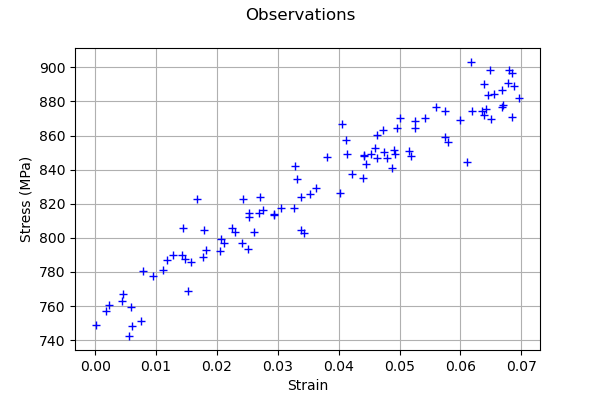

In [10]:
graph = ot.Graph("Observations", "Strain", "Stress (MPa)", True)
cloud = ot.Cloud(observedStrain, observedStress / 1.0e6)
graph.add(cloud)
graph

Notice that the output stress depends almost linearily on the strain. We will see later that the actual model has a small but significant nonlinearity. The vertical deviation of the points from this curve depends on the observation noise.  

## Set the calibration parameters

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*. In this example, we use deterministic methods so that this is just the initial point of the least squares method. 

In [11]:
R = 700e6  # Exact : 750e6
C = 2500e6  # Exact : 2750e6
Gamma = 8.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

The following statement create the calibrated function from the model. The calibrated parameters R, C, Gamma are at indices 1, 2, 3 in the inputs arguments of the model.

The `mycf` function has:
* one input, the strain $\epsilon$,
* one output, the stress $\sigma$.

We want to calibrate this function i.e. we want to search for the values of the parameters R, C, Gamma that reduce the discrepancy between output observations and predictions. 

In [12]:
calibratedIndices = [1, 2, 3]
mycf = ot.ParametricFunction(g, calibratedIndices, thetaPrior)

## Calibration with linear least squares

The `LinearLeastSquaresCalibration` class performs the linear least squares calibration by linearizing the model in the neighbourhood of the reference point. We use the Singular Value Decomposition (SVD) to solve the linear least squares problem. 

In [13]:
algo = ot.LinearLeastSquaresCalibration(
    mycf, observedStrain, observedStress, thetaPrior, "SVD"
)

The `run` method computes the solution of the problem.

In [14]:
algo.run()

In [15]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$. In the linear least squares setting, this is the solution $\theta^\star$ of the linear least squares problem. 

In [16]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.47737e+08,2.79045e+09,10.3362]

We can compute a 95% confidence interval of the parameter $\theta^\star$. This confidence interval makes the assumption that the observation errors are Gaussian (otherwise the confidence interval is wrong). 

In [17]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.39694e+08,2.24973e+09,-530.441] upper bound=class=Point name=Unnamed dimension=3 values=[7.55779e+08,3.33117e+09,551.114] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that R, C parameters have a relatively small confidence interval, but Gamma has a very large confidence interval. The conclusion is that Gamma is not identifiable in this problem: its variability has no influence on the variability of the output. 

In order to understand the results more deeply, we draw several graphics. 

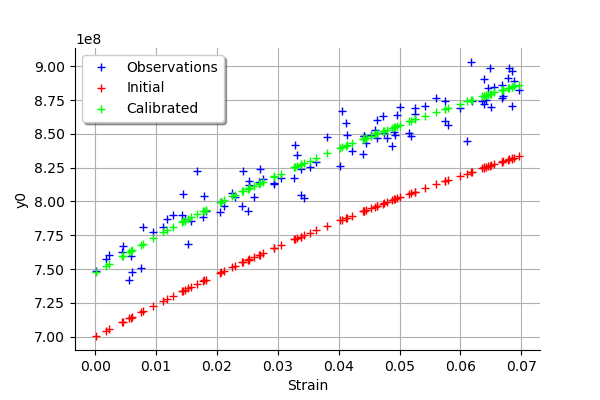

In [18]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

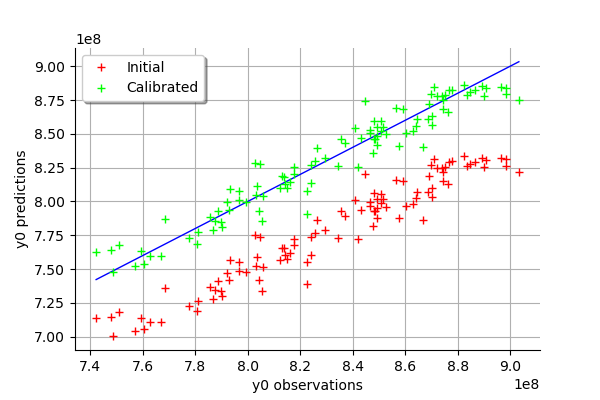

In [19]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

In [20]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1.10416e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

We see that the estimated standard deviation of the observation noise is $11.04 \times 10^6$ is is a relatively accurate estimate of the true value. 

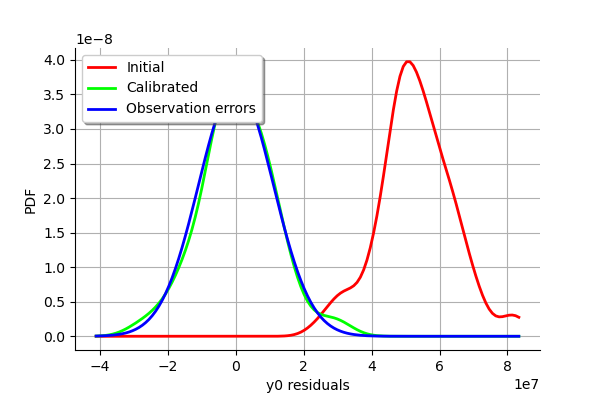

In [21]:
graph = calibrationResult.drawResiduals()
graph.setLegendPosition("topleft")
graph

The analysis of the residuals (the blue curve) shows that the distribution is centered on zero and symmetric. 
Moreover, the distribution of the residuals is close to being gaussian. 
This indicates that the calibration performed well. The confidence intervals that we computed for $\theta^\star$ are therefore valid and can be trusted. 

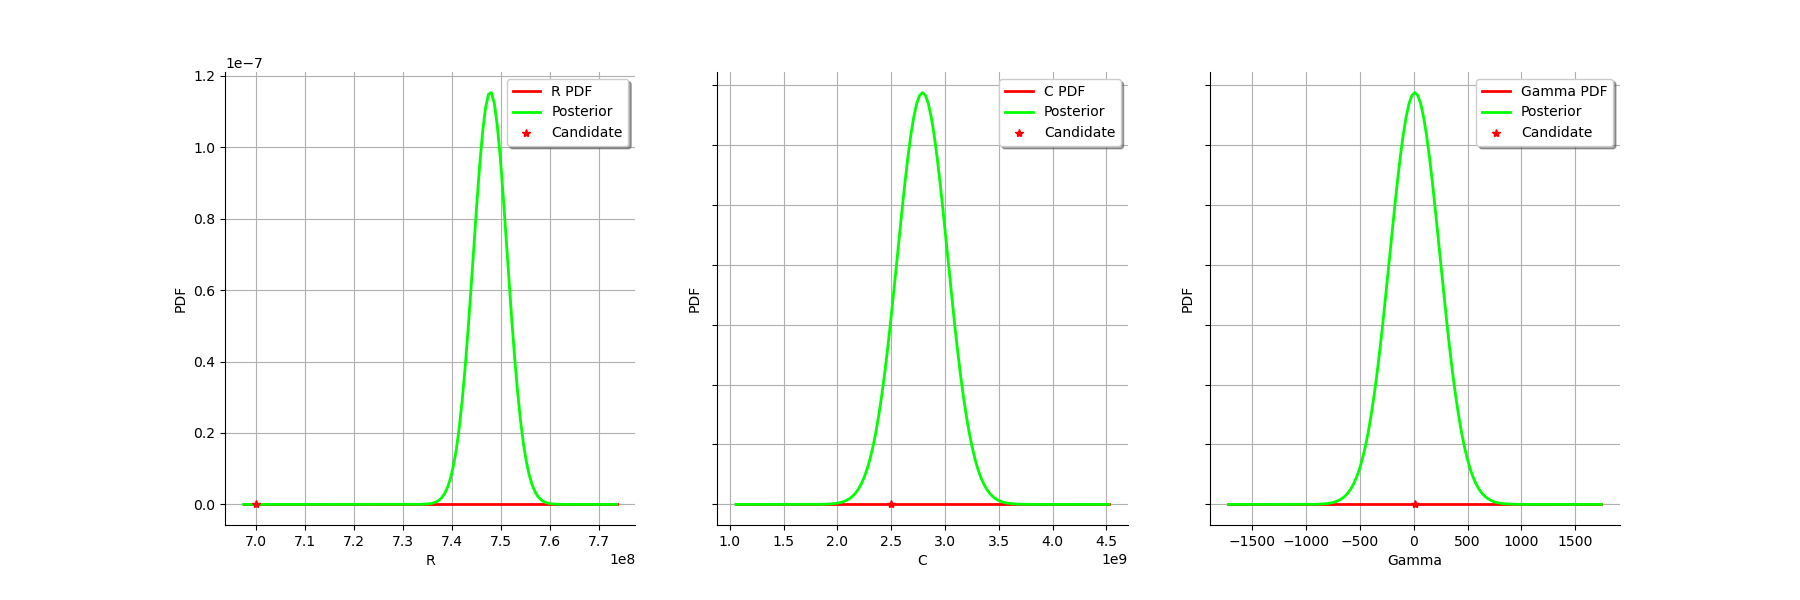

In [22]:
calibrationResult.drawParameterDistributions()

We see that R and C can be estimated with relatively good accuracy. The Gamma parameter, however, cannot be identified. 

## Calibration with nonlinear least squares

The `NonLinearLeastSquaresCalibration` class performs the non linear least squares calibration by minimizing the squared euclidian norm between the predictions and the observations.

In [23]:
algo = ot.NonLinearLeastSquaresCalibration(
    mycf, observedStrain, observedStress, thetaPrior
)

The `run` method computes the solution of the problem.

In [24]:
algo.run()

In [25]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [26]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.47944e+08,2.78913e+09,10.1918]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [27]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.40321e+08,2.22266e+09,3.77251] upper bound=class=Point name=Unnamed dimension=3 values=[7.56611e+08,3.41501e+09,17.1397] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that R, C parameters have a relatively small confidence interval, but Gamma has a relatively large confidence interval. The conclusion is that Gamma cannot be identified with good accuracy. 

Notice however that the confidence interval for Gamma is smaller than with the previous linear model. This shows that the model has some nonlinearity that must be taken into account. 

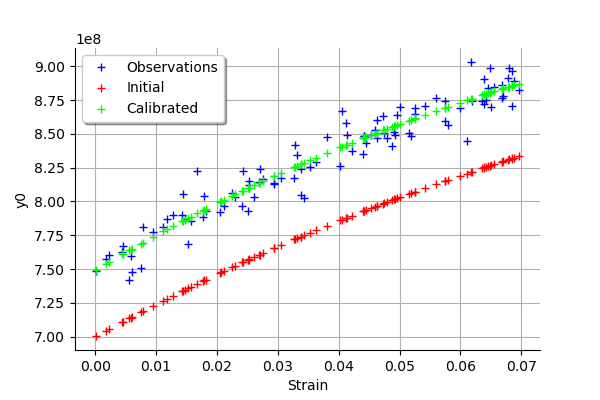

In [28]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

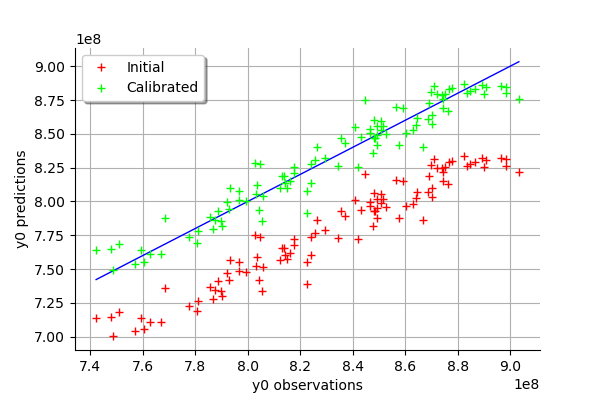

In [29]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

In [30]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[1474.55] sigma=class=Point name=Unnamed dimension=1 values=[1.09998e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

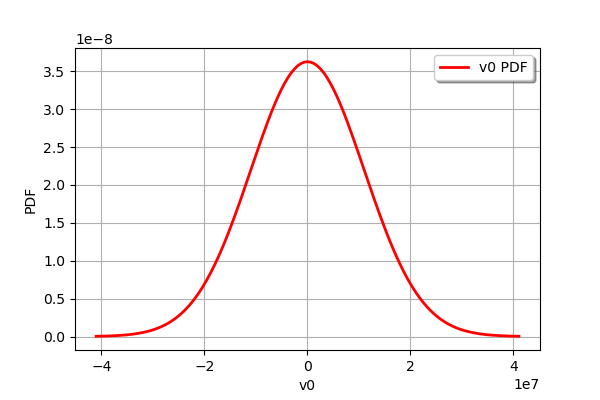

In [31]:
observationError.drawPDF()

The distribution of the observation error is Gaussian, with a standard deviation estimate equal to $10.99\times 10^6$.

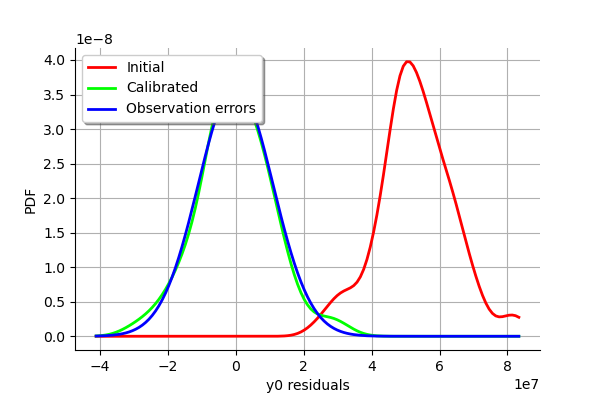

In [32]:
graph = calibrationResult.drawResiduals()
graph.setLegendPosition("topleft")
graph

The analysis of the residuals shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. 

Moreover, the distribution of the residuals is close to being gaussian. This indicates that the observation error might be gaussian.

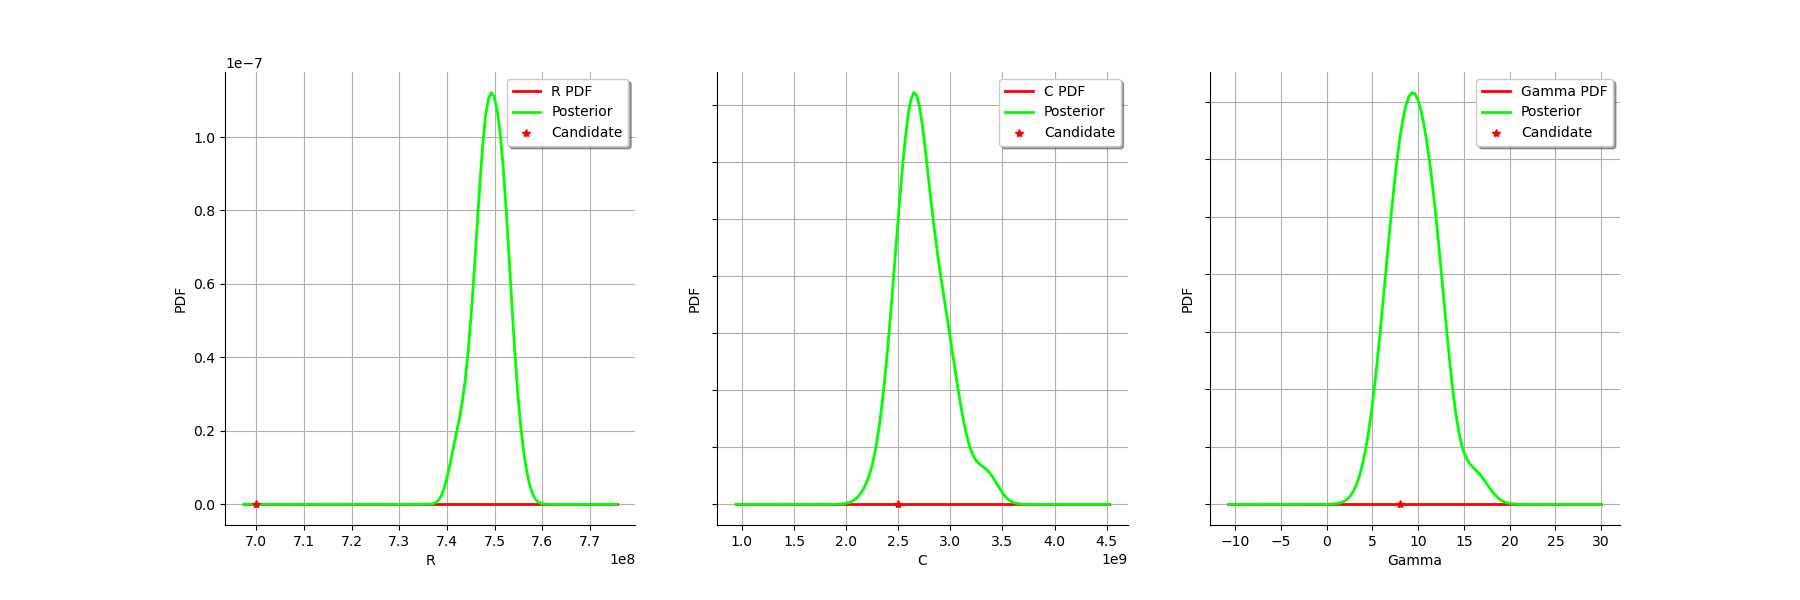

In [33]:
calibrationResult.drawParameterDistributions()

## Exercice 1 : changement du paramètre de référence

* Changer le paramètre `thetaPrior` et utiliser les valeurs numériques suivantes :

In [34]:
R = 650e6  # Exact : 750e6
C = 2300e6  # Exact : 2750e6
Gamma = 6.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

* Comment évolue la valeur du paramètre optimal dans le cas des moindres carrés linéaires ? Pouvez-vous expliquer les causes de ces différences ?
* Comment évolue la valeur du paramètre optimal dans le cas des moindres carrés non-linéaires ? Pouvez-vous expliquer les causes de ces différences ?

## Exercice 2 : réduire la dimension

Au lieu d'ajuster les paramètres R, C et Gamma, on se propose d'ajuster uniquement R et C en utilisant la valeur de Gamma suivante :

In [35]:
Gamma = 8.0  # Exact : 10

Pour cela, utiliser le code suivant, qui permet de définir un modèle dont les seuls paramètres sont R et C.

In [36]:
def modelChabocheGammaFixe(X):
    strain, R, C = X
    gamma = 8.0
    stress = R + C * (1.0 - np.exp(-gamma * strain)) / gamma
    return [stress]


gGammaFixe = ot.PythonFunction(3, 1, modelChabocheGammaFixe)
gGammaFixe.setInputDescription(["Strain", "R", "C"])
gGammaFixe.setOutputDescription(["Stress"])

R = 700e6  # Exact : 750e6
C = 2500e6  # Exact : 2750e6
thetaPriorGammaFixe = ot.Point([R, C])

calibratedIndices = [1, 2]
mycfGammaFixe = ot.ParametricFunction(
    gGammaFixe, calibratedIndices, thetaPriorGammaFixe
)

On considère dans les questions qui suivent un calage par moindres carrés linéaires.

* Quelle est la valeur du paramètre optimal ? Quels sont les changements par rapport à la situation précédente, dans laquelle le paramètre Gamma était calé ?
* Quelle est la qualité du calage obtenu ?
* Qu'est-ce que ces changements impliquent du point de vue du modèle ?

## Exercice 3 : calage et indices de Sobol'

On souhaite observer le lien entre calage et analyse de sensibilité globale. En effet, il semble que les variables R, C et Gamma n'ont pas le même effet sur le modèle. En particulier, il semble que la distribution gaussienne du paramètre Gamma optimal est extrêment large dans le cas des moindres carrés linéaires. 

Pour cette raison, on créer un nouveau modèle `myFunctionH` dont les entrées sont les variables R, C et Gamma. Dans ce modèle, la déformation `Strain` est considérée comme constante et égale à la déformation maximale. Ce choix de paramétrage permet de se situer dans la plage de variation dans laquelle le modèle est le plus nonlinéaire. 

In [37]:
strainReferenceValue = ot.Point([0.07])
strainReferenceValue

class=Point name=Unnamed dimension=1 values=[0.07]

In [38]:
strainIndex = [0]
myFunctionH = ot.ParametricFunction(g, strainIndex, strainReferenceValue)
myFunctionH

class=FunctionImplementation name=Unnamed description=[R,C,Gamma,y0] evaluationImplementation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,y0] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,y0] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[Strain] values=[0.07] input positions=[1,2,3] gradientImplementation=class=ParametricGradient evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,y0] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,y0] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[Strain] values=[0.07] input positions=[1,2,3] hessianImplementation=class=ParametricHessian evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,y0] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,y0] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[Strain] values=[0.07] input positions=[1,2,3]

La distribution des paramètres R, C et Gamma est inconnue. Dans ce contexte, nous considérons des distributions gaussiennes associés à un coefficient de variation de 20%.

In [39]:
def NormalFromMuCV(mu, cv):
    """Create a Normal from its mean and its coeff. of var."""
    sigma = mu * cv
    distribution = ot.Normal(mu, sigma)
    return distribution

In [40]:
cv = 0.2
R = NormalFromMuCV(650.0e6, cv)
R.setDescription(["R"])
C = NormalFromMuCV(2300.0e6, cv)
C.setDescription(["C"])
Gamma = NormalFromMuCV(6.0, cv)
Gamma.setDescription(["Gamma"])
inputDistribution = ot.ComposedDistribution([R, C, Gamma])

On souhaite désormais estimer la sensibilité de la fonction `myFunctionH`  en fonction des entrées R, C et Gamma. 
* Estimer les indices de sensibilité de Sobol' de la fonction `myFunctionH` par rapport à R, C et Gamma. Pour cela, utiliser la classe `SobolSimulationAlgorithm` associée à l'estimateur `SaltelliSensitivityAlgorithm`.
* Quelles sont les variables influentes et peu influentes ?
* Que conclure par rapport au calage ?

## Exercice 4 : linéarité du modèle

On observe que le calage linéaire donne des résultats proches du calage non linéaire en termes de valeurs optimales, mais que les distributions des paramètres optimaux estimés sont assez différentes. C'est pourquoi on souhaite voir à quel point la contrainte est linéaire en fonction des paramètres, c'est à dire qu'on souhaite voit si la fonction `myFunctionH` est linéaire par rapport à R, C et Gamma.  

* Créer un échantillon d'entrée de taille 1000 à partir de la distribution `inputDistribution`. 
* Créer un échantillon de sortie à partir de l'échantillon d'entrée précédent et de la fonction `myFunctionH`. 
* Utiliser la classe `LinearLeastSquares` et créer un modèle linéaire. 
* Calculer le coefficient R2: le modèle est-il approximativement linéaire ?
* Calculer les indices Standardized Regression Coefficients (SRC) de la fonction `myFunctionH` par rapport à Epsilon, R, C et Gamma. Sont ils proches des indices de Sobol' ?